# Problem 3

In [113]:
import pandas as pd
from scipy.io import loadmat

data_train = loadmat('./p3/training_data.mat')
data_test = loadmat('./p3/test_data.mat')

In [110]:
pd.DataFrame({"x":data_train["x"].T[0],"y":data_train["y"].T[0]})

,x,y
0,-1.027161,1.132930
1,1.411778,1.760974
2,1.371501,2.055579
3,-0.043873,0.218921
4,0.900841,0.900883
5,-1.074341,1.283079
6,-0.234716,0.176658
7,1.247207,1.501638
8,0.876622,0.846205
9,1.378477,1.735793


### (a2)  plot the fitted curve

In [111]:
import numpy as np

def para(x):
    return [x**i for i in range(9)]

X = np.mat([para(i) for i in data_train["x"].T[0]])
theta_tilda = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_train["y"])

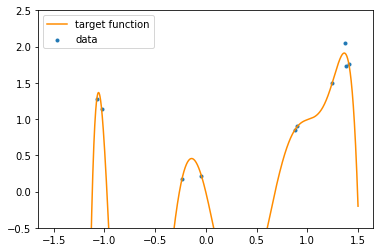

In [112]:
import matplotlib.pyplot as plt

def func(x):
    return np.array(para(x)).dot(np.array(theta_tilda).T[0])

x_plot = np.linspace(-1.5, 1.5, num=2000)
y_plot = list(map(func, list(x_plot)))
plt.plot(x_plot,y_plot, c='darkorange', label='target function')
plt.ylim(-0.5, 2.5)
plt.scatter(data_train["x"].T[0], data_train["y"].T[0], marker='.', label='data')
plt.legend()
plt.show()


### (a3)   calculate the test error

In [122]:
np.linalg.norm(np.array(list(map(func, list(data_test["x_test"].T[0]))))-data_test["y_test"].T[0], ord=2)

177.23120575454834

### (b1)  5-fold CV for lambda

In [315]:
import numpy as np 

class Model:
    def __init__(self, lambda_):
        self.lambda_ = lambda_
        self.theta = None
    
    def para(self, x):
        return [x**i for i in range(9)]

    def model_fit(self, x_train, y_train):
        '''
        lambda_: scalar
        x_train: array, (n,)
        y_train: array, (n,)
        
        RETURN: no actual return
        instancialized model with updated theta.
        self.theta: mat, (9,1)
        '''
        # When doing cross validation, you cannot just throw the whole training dataset into the model.  
        X = np.mat([self.para(i) for i in x_train])

        l = len(X.T.dot(X))
        y_train = np.mat(y_train).T # change it into (1,n)
        theta_tilda = np.linalg.inv(X.T.dot(X) + np.diag([self.lambda_ for i in range(l)])).dot(X.T).dot(y_train)
        self.theta = theta_tilda

        return self
      
    def model_predict(self, x_test):

        def func(x):
            '''the scalar output of y for scalar input of x'''
            return np.array(self.para(x)).dot(np.array(self.theta).T[0])

        return np.array(list(map(func, list(x_test))))
            
   

In [258]:
# Test on the class Model
model = Model(lambda_=0)

model.model_fit(data_train["x"].T[0], data_train["y"].T[0])
# model.theta.shape
y_test_pred = model.model_predict(data_test["x_test"].T[0])

In [275]:
# Implement cross validation with KFold

from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

X = data_train["x"].T[0]
y = data_train["y"].T[0]
lambda_set = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.3, 0.5, 0.8, 1, 2, 5, 10, 15, 20, 50, 100]

error_total = [] # To record error lists for each validation, should be an array of (5,16)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    error_per_lambda = [] # To record error for each lambda
    for lambda_ in lambda_set:
        model = Model(lambda_)
        model.model_fit(X_train, y_train)
        # print("theta", '\n', model.theta.shape)
        y_test_pred = model.model_predict(X_test)

        error = np.linalg.norm(y_test_pred - y_test, ord=2)
        error_per_lambda.append(error)
    
    error_total.append(error_per_lambda)


In [276]:
np.mean(error_total, axis=0)


array([0.96283053, 0.5759208 , 0.2936302 , 0.2498516 , 0.21654502,
       0.19710412, 0.1961509 , 0.20538331, 0.21497739, 0.27269545,
       0.40503773, 0.5300326 , 0.60316818, 0.65183047, 0.77735623,
       0.84484377])

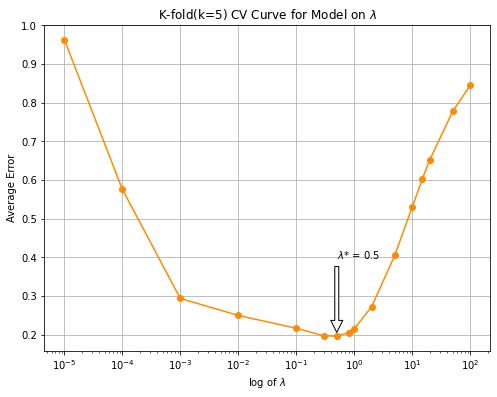

In [310]:
# Visualization
lambda_star = lambda_set[list(np.mean(error_total, axis=0)).index(min(np.mean(error_total, axis=0)))]

plt.figure(1, figsize=(8, 6))
plt.xscale("log")
plt.ylabel("Average Error")
plt.xlabel("log of $\lambda$")
plt.title(f"K-fold(k={5}) CV Curve for Model on $\lambda$")
plt.plot(lambda_set, np.mean(error_total, axis=0), marker='o', color="darkorange")
plt.annotate('$\lambda$* = %s' %lambda_star,
              xy=(lambda_star, min(np.mean(error_total, axis=0))),
              xytext =(lambda_star, min(np.mean(error_total, axis=0))+0.2),
              arrowprops=dict(facecolor='white',shrink=0.05),
              xycoords=('data'))
plt.grid(True)
plt.show()



### (b2)  Draw fitted curves

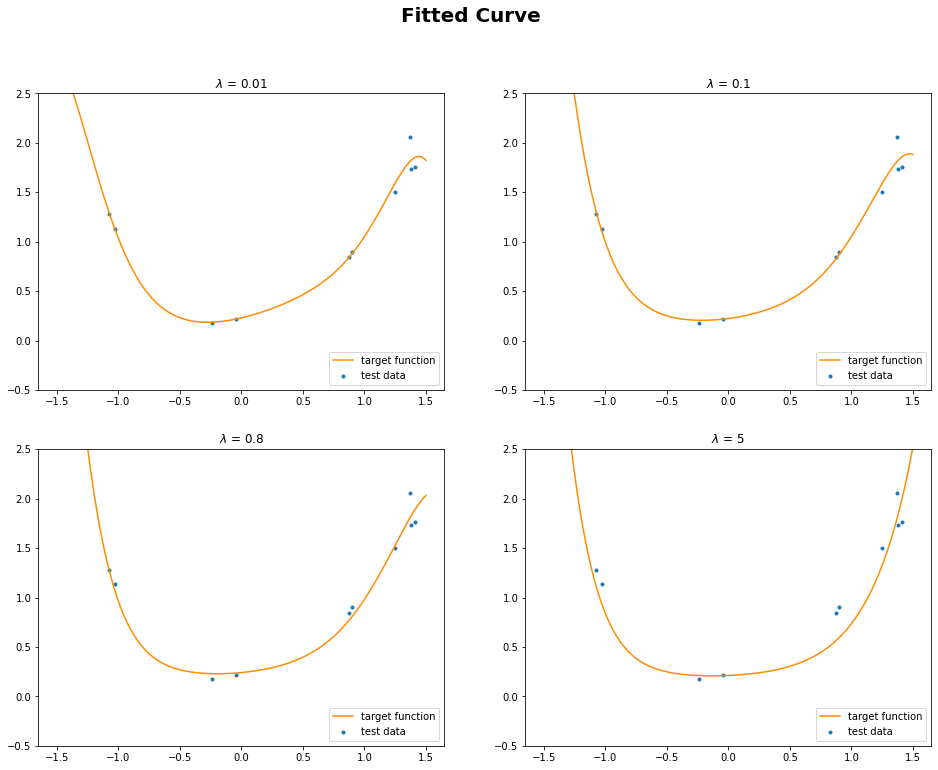

In [322]:
fig, ax = plt.subplots(2,2,figsize=(16,12))
iter = 0

x_plot = np.linspace(-1.5, 1.5, num=200)
lambda_set = [0.01, 0.1, 0.8, 5]

for i in range(2):
    for j in range(2):
        
        model = Model(lambda_set[iter])
        model.model_fit(data_train["x"].T[0], data_train["y"].T[0])
        y_plot = model.model_predict(x_plot)
        
        ax[i, j].plot(x_plot, y_plot, c='darkorange', label='target function')
        ax[i, j].scatter(data_train["x"].T[0], data_train["y"].T[0], marker='.', label='test data')
        ax[i, j].set_ylim(-0.5, 2.5)
        ax[i, j].legend(loc='lower right')
        ax[i, j].set_title(f'$\lambda$ = {lambda_set[iter]}', fontsize=12)

        iter += 1

fig.suptitle('Fitted Curve', fontsize=20, fontweight='bold')
plt.show()

### (b3)   calculate the test error

In [330]:
lambda_set = [0.01, 0.1, 0.8, 5]
for lambda_ in lambda_set:
    model = Model(lambda_)
    model.model_fit(data_train["x"].T[0], data_train["y"].T[0])
    y_test_pred = model.model_predict(data_test['x_test'].T[0])

    res = np.linalg.norm(y_test_pred - data_test["y_test"].T[0], ord=2)
    print(f"for lambda = {lambda_}, the test error is {res:.3f}")


for lambda = 0.01, the test error is 1.206
for lambda = 0.1, the test error is 3.694
for lambda = 0.8, the test error is 4.114
for lambda = 5, the test error is 3.491
